### *Introduction*
This notebook contains:
 - A picture of Phil the groundhog
- A brief visual summary of average temperature trends in the US over the last century between February and March
- An evaluation of Phil's predictive performance at both the national and local levels

### *Phil the Puxsutawney Groundhog*

![Phil][1]


  [1]: https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Marmota_monax_UL_04.jpg/800px-Marmota_monax_UL_04.jpg

Phil, age 130.

### *Exploration of Temperature Trends in the US Over the Last Century*

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use(['bmh'])
rng = np.random.RandomState(42)
# Nb. Sees his shadow -> Predicts more winter -> Colder(?)

def f2c(farenheit): # Farenheit to celsius
    return (farenheit - 32)*(5/9)

def filled_kde(series, size=(8, 4)): # Fast filled KDE axes
    ax = series.plot(kind='kde', lw=1, figsize=size)
    kde = ax.get_lines()[0].get_xydata()
    ax.fill_between(kde[:, 0], 0, kde[:, 1], alpha=0.1)
    return ax

data = pd.read_csv('../input/archive.csv').dropna(axis=0, how='any')
avg_temp = data[['February Average Temperature', 'March Average Temperature']]

plt.figure(figsize=(8, 4))
plt.plot(data['Year'], f2c(avg_temp), '-o', markersize=5, lw=1, markeredgecolor='#efefef')
plt.xlabel('Year', size=11); plt.ylabel('Average temperature [$^\circ$C]', size=10)
plt.title('US Average Temperatures, 1895-2016', size=10)
plt.legend(["February", "March"], loc=2);

There is a distinctive upward trend in the average temperature in February and March across the whole country. The temperature seems to be increasing at a rate of about 0.017°C/year. 

In [ ]:
from scipy.stats import linregress
feb = linregress(range(len(avg_temp)), f2c(avg_temp).ix[:, 0])
print('Linear fit estimates that the avg. temperature across the US is increasing at a rate of '+str(round(feb.slope, 3))+' degrees Celsisus per year, based on information from the last century.')

In [ ]:
# Assume !(Full Shadow) -> Predicts it will get warmer by more than average
#               Shadow  -> Predicts it will get warmer by less than average
sees_shadow = pd.get_dummies(data['Punxsutawney Phil']).iloc[:, 0].astype(int)
phils_predictions = -sees_shadow + (1 - sees_shadow)
temperature_change = data['March Average Temperature'] - data['February Average Temperature']
temperature_dev = f2c(temperature_change) - f2c(temperature_change.mean())

positive_yr = data['Year'].ix[temperature_dev>0]
positive_tmp = temperature_dev[temperature_dev>0]
negative_yr = data['Year'].ix[temperature_dev<0]
negative_tmp = temperature_dev[temperature_dev<0]

plt.figure(figsize=(8, 4))
(markerline, stemlines, baseline) = plt.stem(positive_yr, positive_tmp);
plt.setp(baseline, visible=False); 
plt.setp(markerline, markersize=5, markeredgecolor='#ffffff', markerfacecolor='#4693c2');
plt.setp(stemlines, color='#4693c2', lw=1.5);

(markerline, stemlines, baseline) = plt.stem(negative_yr, negative_tmp);
plt.setp(baseline, visible=False); 
plt.setp(markerline, markersize=5, markeredgecolor='#ffffff', markerfacecolor='#B02643');
plt.setp(stemlines, color='#b02643', lw=1.5);
plt.ylim(-8, 8); plt.ylabel('Temperature change [$^\circ$C]', size=10)
plt.xlabel('Year', size=10)
plt.title('Deviation in Avg. Temperature Change from Feb. to March, US, 1985-2016', size=10)
plt.show()

The plot above shows how much the temperature changed for a given year, relative to how much it usually changes. As we'll see later, these changes are more or less normally distributed. This suggests that the severity of the temperature change between February and March has been consistent across the last century. 

In [ ]:
ax = filled_kde(temperature_dev)
plt.title('Temperature Change Deviations between Feb and March, USA, 1895-2016', size=10);
plt.xlabel('Deviation from mean temperature change [$^\circ$C]', size=10)
plt.ylabel('Density', size=10);

As we can see, the temperature change is above the average temperature change about as much as it's below it. Verifying this quantitatively:

In [ ]:
np.sign(temperature_dev).value_counts() # 1-> Above avg change, -1 -> Below avg change

### *Testing Phil*

In [ ]:
data['Punxsutawney Phil'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title('What Phil Sees', size=10); plt.ylabel('Count', size=10);
plt.xticks(rotation=0);
plt.text(-0.5, -15, '*Full shadow $\Rightarrow$ Phil predicts the next few weeks will be colder than usual', size=8);

In [ ]:
# Phil's accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(np.sign(temperature_dev), phils_predictions)

In [ ]:
# Compare this to a dummy classifier
dummy_predictions = np.random.choice([-1, 1], len(temperature_dev), replace=True)
accuracy_score(np.sign(temperature_dev), dummy_predictions)

Don't worry Phil - I still believe in you : )

### *Addendum - testing linear fit assumptions*

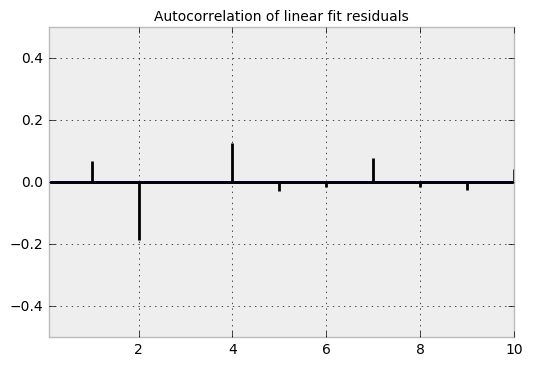

In [35]:
# Testing of linear fit assumptions
# --------------------
linear_estimates = feb.intercept + feb.slope*np.arange(0, len(avg_temp))

# Assumption 1: Errors aren't autocorrelated
residuals = f2c(avg_temp.ix[:,0]) - linear_estimates
plt.acorr(residuals, maxlags=None); plt.xlim(0.1, 10); plt.ylim(-0.5, 0.5)
plt.axhline(0, color='black', lw=2);
plt.title('Autocorrelation of linear fit residuals', size=10); # They aren't...

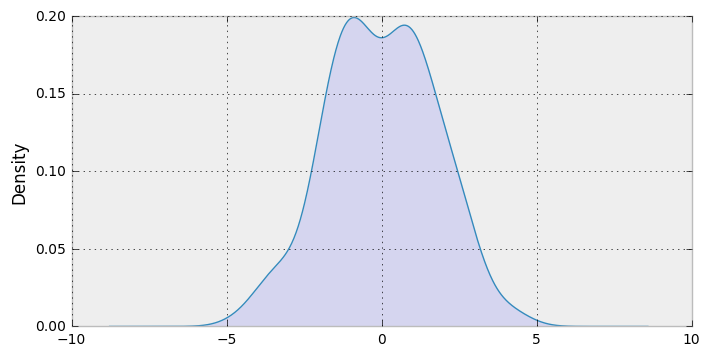

In [ ]:
# Assumption 2: Errors are normally distributed
filled_kde(pd.Series(residuals)); # More or less...

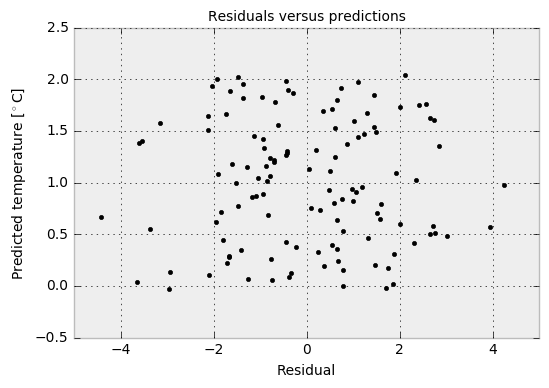

In [34]:
# Assumption 3: Error variance is invariant with time, error, and response
plt.plot(residuals, linear_estimates, 'k.') # Should look uncorrelated a.f.
plt.title('Residuals versus predictions', size=10)
plt.xlabel('Residual', size=10); plt.ylabel('Predicted temperature [$^\circ$C]', size=10);
# TBC...